In [1]:
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
import os
import subprocess
from pyspark.sql import SparkSession

runLocal = False

if runLocal:
    spark  = SparkSession.builder.master('local').appName('minst').getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('minst') \
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

Spark Session web UI: http://10.50.222.118:4040


In [7]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import seaborn
import sklearn.decomposition
import scipy.linalg
import math
import pandas
%matplotlib inline

import pyspark.sql.functions
import pyspark.mllib.clustering
import pyspark.mllib.classification
from pyspark.mllib.classification import LabeledPoint
from pyspark.mllib.linalg import  SparseVector, DenseMatrix, DenseVector

import re
import functools

In [8]:
dfclean = spark.read.json('/project/cmsc25025/mnist/data.json')

In [9]:
df = dfclean#.sample(False, .01, seed=123)

In [10]:
def reg(x):
    v = np.array(x['features'])
    return x['label'], (v - v.mean()) / v.std()

regged = df.rdd.map(reg).cache()

# Part 1: PCA

## Section a

In [11]:
pcaComps = 10

def pca(rd, numComponents):
    covs = regged.map(lambda x : np.outer(x[1], x[1]))
    covMat = covs.sum()
    U, D, V = scipy.linalg.svd(covMat)
    #It looks like they are already sorted by scipy
    #but the docs don't mention it and sorting is cheap
    Dsort = D.argsort()
    return V[Dsort][:-numComponents - 1:-1], D[Dsort][:-numComponents - 1:-1]

def testPCA(rd, numComponents):
    B = np.stack(rd.map(lambda x: x[1]).collect(), axis = 1)
    clf = sklearn.decomposition.PCA(numComponents)
    #This produces a differently shape matrix than my method
    return clf.fit_transform(B)

def plotVecs(mat, matTest):
    figSize = 3
    n = mat.shape[0]
    fig, axes = plt.subplots(ncols = 2,
                             nrows=n,
                             figsize = (figSize * 2, figSize * n))
    
    for i in range(n):
        vec1 = mat[i, :]
        vec2 = matTest[:, i]
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]
        ax1.axis('off')
        ax1.set_title('${}^{{th}}$ PCA component'.format(i + 1))
        hmap = ax1.pcolor(vec1.reshape(28,28)[::-1,:])
        ax2.axis('off')
        ax2.set_title('${}^{{th}}$ PCA component Test'.format(i + 1))
        hmap = ax2.pcolor(vec2.reshape(28,28)[::-1,:])
    
    fig.tight_layout()
    #matplotlib bug
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Section a: First {} PCA components comparison".format(n), fontsize=20)
    plt.show()
    plt.close()

pcaMat, variance = pca(regged, pcaComps)
pcaTest = testPCA(regged, pcaComps)

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


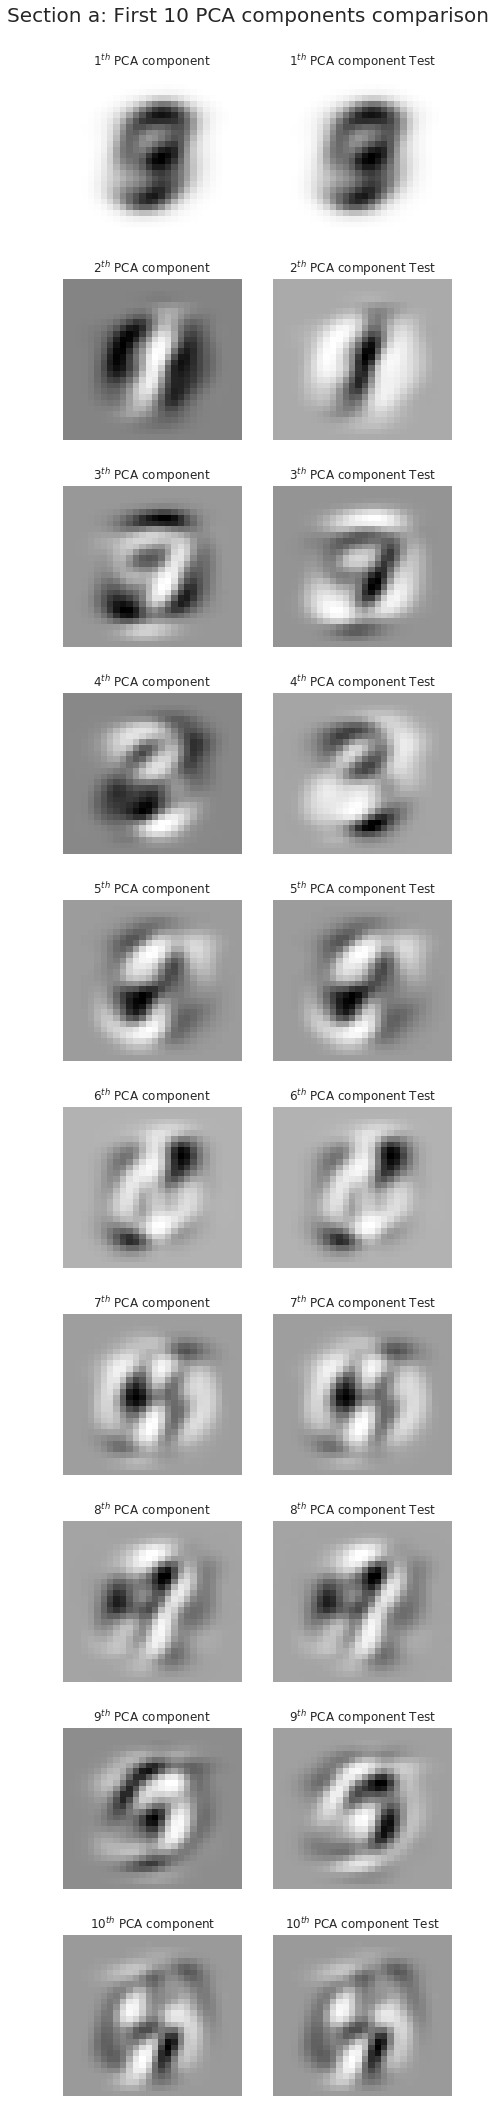

In [12]:
plotVecs(pcaMat, pcaTest)

## Section b

In [13]:
def secB(variance):
    figSize = 6
    fig, ax = plt.subplots(figsize = (figSize * 2, figSize))
    ax.plot(variance)
    ax.set_title("Section b: Sample Variance vs PCA Component Number", fontsize = 20)
    ax.set_ylabel('Sample Variance')
    ax.set_xlabel("PCA Component Number")
    plt.show()
    plt.close()
    #ax.set_xscale("log")

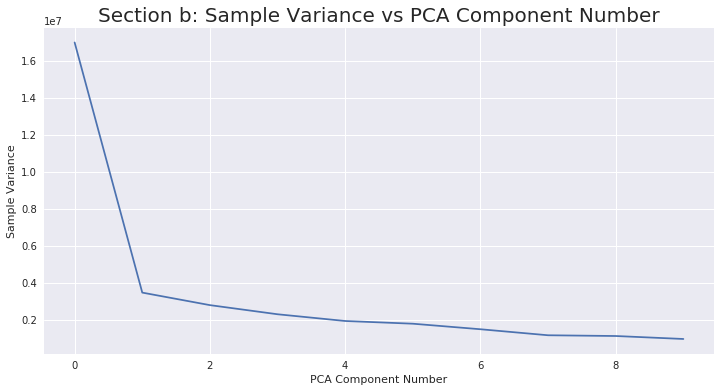

In [14]:
secB(variance)

## Section c

In [15]:
def reconLoss(intial, final):
    delta = intial - final
    return np.sum(delta * delta)

def secC(rd, mVals, perM):
    figSize = 2
    n = len(mVals) * perM
    fig, axes = plt.subplots(ncols = perM * 2,
                             nrows=len(mVals),
                             figsize = (figSize * perM * 2, figSize * len(mVals)))
    fig.suptitle("Section c: Dimension reduction effects", fontsize=20)
    points = rd.sample(False, 1, seed = 1234).take(perM)
    maxPCA, variance = pca(rd, max(mVals))
    for i, m in enumerate(mVals):
        #Since PCA mat is sorted
        mat = maxPCA[:m]
        for j in range(perM):
            p = points[j][1]
            newP = mat.dot(p).dot(mat)
            ax1 = axes[i, 0 + j * 2]
            ax2 = axes[i, 1 + j * 2]
            ax1.set_title("Before $m = {}$, point {}".format(m , j + 1), fontsize=8)
            ax2.set_title("After, loss {:.2f}".format(reconLoss(p, newP)), fontsize=8)
            ax1.axis('off')
            ax2.axis('off')
            hmap = ax1.pcolor(p.reshape(28,28)[::-1,:])
            hmap = ax2.pcolor(newP.reshape(28,28)[::-1,:])
    plt.show()
    plt.close()

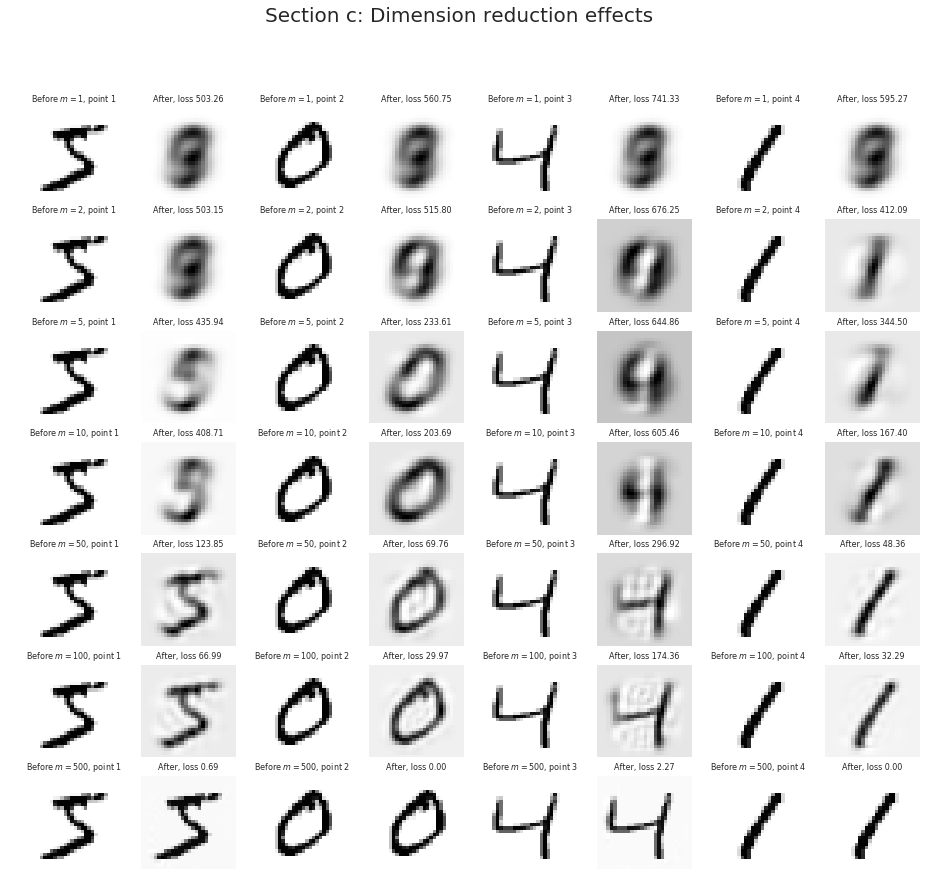

In [16]:
mVals = [1, 2, 5, 10, 50, 100, 500]

secC(regged, mVals, 4)

## Section d

In [17]:
def secD(rd, mVals):
    figSize = 6
    fig, ax = plt.subplots(figsize = (figSize * 2, figSize))
    losses = []
    maxPCA, variance = pca(rd, max(mVals))
    for m in mVals:
        mat = maxPCA[:m]
        reErrRDD = rd.map(lambda x: reconLoss(x[1], mat.dot(x[1]).dot(mat)))
        losses.append(reErrRDD.mean())
    ax.plot(mVals, losses)
    ax.set_title("Section d: Reconstruction Error vs Number of PCA dimensions", fontsize = 20)
    ax.set_xlabel("Number of PCA dimensions")
    ax.set_ylabel("Reconstruction Error")
    #Worth considering
    #ax.set_xscale("log")

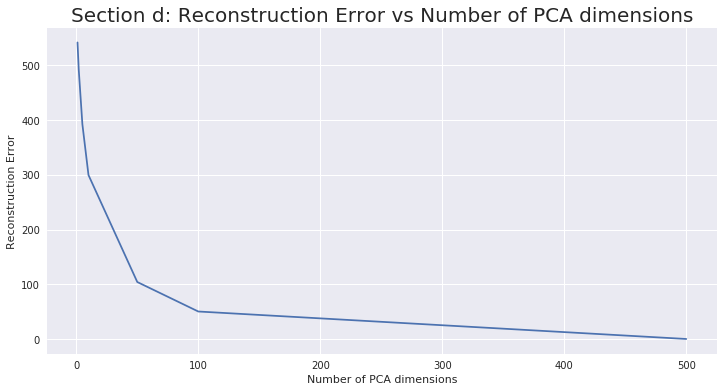

In [18]:
secD(regged, mVals)

# Part 2

In [19]:
def part2(rd, perCluster):
    clusters = pyspark.mllib.clustering.KMeans.train(rd.map(lambda x: x[1]),
                                                     10,
                                                     maxIterations=50,
                                                     initializationMode="random")
    samplePoints = {i : [] for i in range(10)}
    points = rd.sample(False, 1, seed = 1234).take(1000)
    #Bogosort is best sort
    for p in points:
        if len([s for s in samplePoints.values() if len(s) < perCluster]) <= 0:
            break
        pred = clusters.predict(p[1])
        if len(samplePoints[pred]) < perCluster:
            samplePoints[pred].append(p)
    figSize = 1
    fig, axes = plt.subplots(ncols = perCluster,
                             nrows = 10,
                             figsize = (figSize * perCluster, figSize * 10))
    for k, selectedPoints in samplePoints.items():
        labels = {}  
        for i, (label, point) in enumerate(selectedPoints):
            ax = axes[k, i]
            ax.axis('off')
            hmap = ax.pcolor(point.reshape(28,28)[::-1])
            if label in labels:
                labels[label] += 1
            else:
                labels[label] = 1
        rowLabel = sorted(labels.items(), key = lambda x: x[1])[-1][0]
        axes[k, 0].set_title("Cluster \"{}\"".format(rowLabel), loc = 'left')
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Part 2: KMeans clusters", fontsize=20)
    return samplePoints

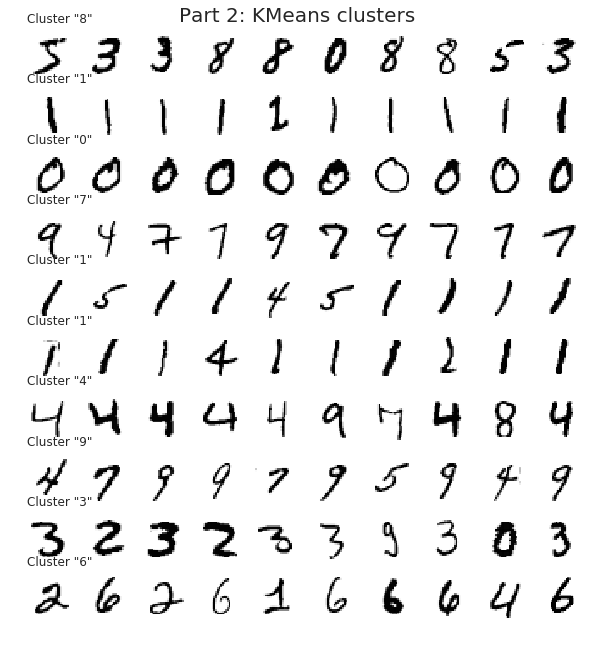

In [20]:
d = part2(regged, 10)

# Part 3

In [21]:
def spectralClustering(rd, h, numDim):
    X = np.stack(rd.map(lambda x: x[1]).collect())
    n = X.shape[0]
    perCluster = 10
    figSize = 1
    rows = []
    for i in range(n):
        xi = X[i]
        row = []
        for j in range(n):
            row.append(np.exp(- np.square(np.linalg.norm(xi - X[j])) / h))
        rows.append(np.array(row))
    A = np.stack(rows)
    D = np.zeros(A.shape, float)
    np.fill_diagonal(D, [np.power(np.sum(A[i]), -.5) for i in range(A.shape[0])])
    L = np.eye(A.shape[0]) - D.dot(A).dot(D)
    U, D, V = scipy.linalg.svd(L)
    #It looks like they are already sorted by scipy
    #but the docs don't mention it and sorting is cheap
    Dsort = D.argsort()
    projMat = V[Dsort][:-max(numDim) - 1:-1].dot(X)
    for dim in numDim:
        mat = projMat[:dim]
        projRDD = rd.map(lambda x: (x[0], mat.dot(x[1])))
        clusters = pyspark.mllib.clustering.KMeans.train(projRDD.map(lambda x: x[1]),
                                                         10,
                                                         maxIterations=50,
                                                         initializationMode="random")
        samplePoints = {i : [] for i in range(10)}
        points = rd.sample(False, 1, seed = 1234).take(1000)
        #Bogosort is best sort
        for p in points:
            if len([s for s in samplePoints.values() if len(s) < perCluster]) <= 0:
                break
            pred = clusters.predict(mat.dot(p[1]))
            if len(samplePoints[pred]) < perCluster:
                samplePoints[pred].append(p)
        
        fig, axes = plt.subplots(ncols = perCluster,
                                 nrows = 10,
                                 figsize = (figSize * perCluster, figSize * 10))
        for k, selectedPoints in samplePoints.items():
            labels = {}  
            for i, (label, point) in enumerate(selectedPoints):
                ax = axes[k, i]
                ax.axis('off')
                hmap = ax.pcolor(point.reshape(28,28)[::-1])
                if label in labels:
                    labels[label] += 1
                else:
                    labels[label] = 1
            rowLabel = sorted(labels.items(), key = lambda x: x[1])[-1][0]
            axes[k, 0].set_title("Cluster \"{}\"".format(rowLabel), loc = 'left')
            
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        fig.suptitle("Part 3: Spectral clustering {} dimensions".format(dim), fontsize=20)
        plt.show()
        plt.close()

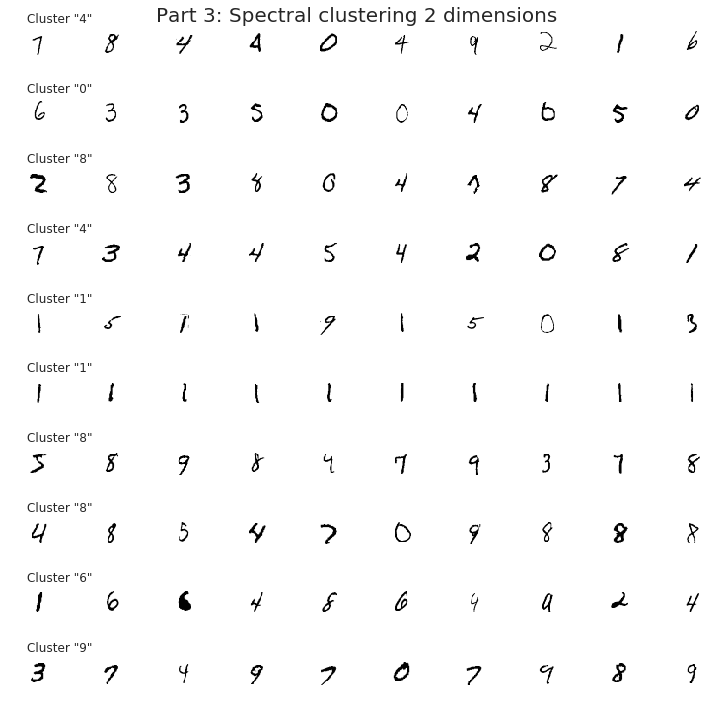

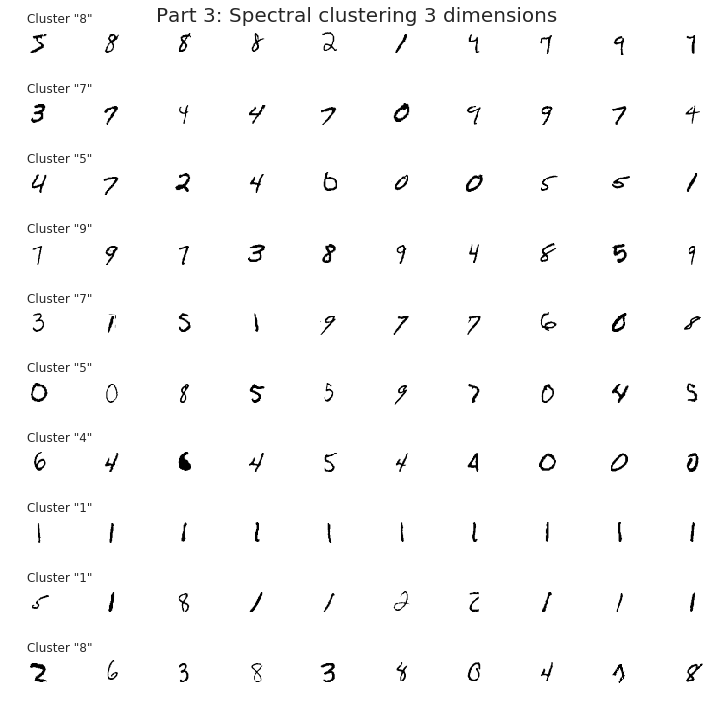

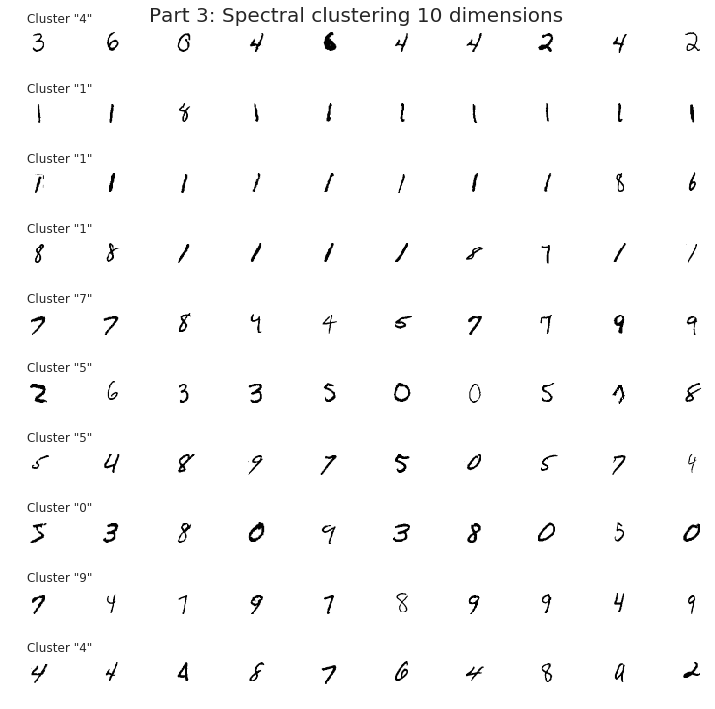

In [22]:
spectralClustering(regged.sample(False, 10000 / regged.count(), seed = 1234), 10000, [2, 3, 10])

# Part 4

In [23]:
train, dev, test = regged.map(lambda x: LabeledPoint(*x)).randomSplit([4, 1, 1], seed = 123)

In [24]:
def secAA(train, dev, mVals):
    figSize = 6
    maxPCA, variance = pca(train, max(mVals))
    errors = []
    for m in mVals:
        mat = maxPCA[:m]
        trainPCA = train.map(lambda x: LabeledPoint(x.label, mat.dot(x.features)))
        modelPCA = pyspark.mllib.classification.LogisticRegressionWithLBFGS.train(trainPCA, iterations = 100, numClasses = 10)
        errors.append(dev.map(lambda x : 0 if modelPCA.predict(mat.dot(x.features)) == x.label else 1).mean())
        
    #No PCA
    #28 * 28
    modelBase = pyspark.mllib.classification.LogisticRegressionWithLBFGS.train(train, iterations = 100, numClasses = 10)
    errors.append(dev.map(lambda x : 0 if modelBase.predict(x.features) == x.label else 1).mean())
    
    
    fig, ax = plt.subplots(figsize = (figSize * 2, figSize))
    ax.plot(mVals + [28 * 28], errors)
    ax.set_title("Part 4 a: Classification Error vs Number of PCA dimensions", fontsize = 20)
    ax.set_xlabel("Number of PCA dimensions")
    ax.set_ylabel("Classification Error")
    return pandas.DataFrame({"Number of PCA dimensions" : mVals + [28 * 28], "Classification Error" : errors}).set_index("Number of PCA dimensions")

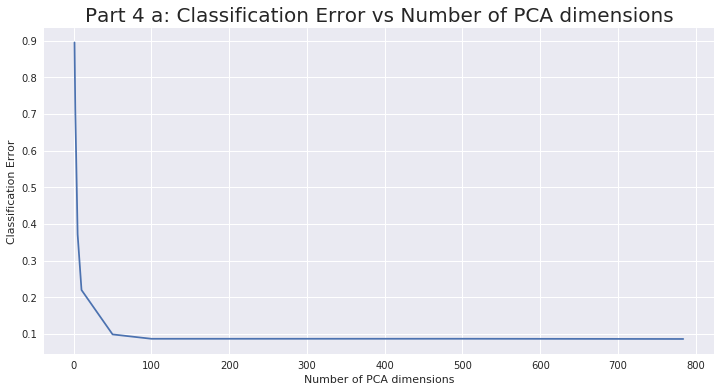

In [25]:
resultsDF = secAA(train, dev, mVals)

In [26]:
print(resultsDF)

                          Classification Error
Number of PCA dimensions                      
1                                     0.894891
2                                     0.710822
5                                     0.371419
10                                    0.219624
50                                    0.098464
100                                   0.086555
500                                   0.086641
784                                   0.086037


In [27]:
def secB(train, dev, test, mVal):
    trainMerge = train.union(dev)
    pcaMat, variance = pca(trainMerge, mVal)
    modelBase = pyspark.mllib.classification.LogisticRegressionWithLBFGS.train(trainMerge, iterations = 100, numClasses = 10)
    errorBase = test.map(lambda x : 0 if modelBase.predict(x.features) == x.label else 1).mean()
    
    trainPCA = trainMerge.map(lambda x: LabeledPoint(x.label, pcaMat.dot(x.features)))
    modelPCA = pyspark.mllib.classification.LogisticRegressionWithLBFGS.train(trainPCA, iterations = 100, numClasses = 10)
    errorPCA = test.map(lambda x : 0 if modelPCA.predict(pcaMat.dot(x.features)) == x.label else 1).mean()
    return errorBase, errorPCA

In [28]:
secB(train, dev, test, 50)

(0.08242044861763172, 0.09720048687184839)